In [1]:
Z_DIM = 10

### 1. Load Colored MNIST dataset

In [2]:
import numpy as np
from PIL import Image, ImageColor
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch import tensor
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.utils as vutils

import torch.distributions.constraints as constraints
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')
import time

import pandas as pd
from tqdm import tqdm

from IPython.display import clear_output

!pip install -q torchsummary
from torchsummary import summary

!pip install -q pyro-ppl
import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD
from pyro.infer import TraceEnum_ELBO, config_enumerate, infer_discrete
pyro.set_rng_seed(0)
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

from matplotlib.gridspec import GridSpec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 34.9 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
colors = [
        'darkgreen', '#6495ed', 'darkblue', '#b03060',
        'orangered', 'yellow', 'burlywood', 'lime',
        'aqua', 'fuchsia',
    ]
color_names = ['darkgreen', 'blue', 'darkblue', 'maroon', 'orangered',
            'yellow', 'burlywood', 'lime', 'aqua', 'fuchsia']
color_dict = {k: v for k, v in enumerate(color_names)}

def get_rgb(x):
    t = torch.tensor(ImageColor.getcolor(x, "RGB")) / 255.
    return t.view(-1, 1, 1)

NUM_COLORS = len(colors)
colors = list(map(get_rgb, colors))
COUNTERFACTUAL_LABELS = [0,2,4,6,8]

class DoubleColoredMNIST(Dataset):
    def __init__(self, train=True, counterfactual=False):
        self.train = train
        self.counterfactual = counterfactual
        self.mnist_sz = 28

        # get mnist
        if train:
            mnist = datasets.MNIST(root='data', download=True, train=True)
        else:
            mnist = datasets.MNIST(root='data', download=True, train=False)
        ims, labels = mnist.data, mnist.targets
        # self.T = transforms.Compose([
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        # ])
        if self.counterfactual:
            self.ims_digit = []
            self.labels = []
            for im, l in zip(torch.stack([ims, ims, ims], dim=1), labels):
                if l.item() in COUNTERFACTUAL_LABELS:
                    self.ims_digit.append(im)
                    self.labels.append(l)
            self.labels = np.array(self.labels)
        else:
            self.ims_digit = torch.stack([ims, ims, ims], dim=1)
            self.labels = labels

    def __getitem__(self, idx):
        digit = self.labels[idx]
        if self.train:
            if digit.item() in COUNTERFACTUAL_LABELS:
                fg_i = np.random.choice([i for i in range(NUM_COLORS) if i != digit])
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i not in [digit, (digit + 1) % NUM_COLORS, fg_i]])
            else:
                fg_i = np.random.choice(NUM_COLORS)
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        elif self.counterfactual:
            fg_i = int(digit)
            bg_i = int((digit + 1) % NUM_COLORS)
        else:
            fg_i = np.random.choice(NUM_COLORS)
            bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        back_color = colors[bg_i].clone()
        back_color += torch.normal(0, 1e-3, (3, 1, 1))
        obj_color = colors[fg_i].clone()
        obj_color += torch.normal(0, 1e-3, (3, 1, 1))

        # get digit
        im_digit = (self.ims_digit[idx] / 255.).to(torch.float32)
        im_digit = F.interpolate(im_digit[None,:], (self.mnist_sz, self.mnist_sz)).squeeze()
        im_digit = (im_digit > 0.1).to(int)  # binarize

        # plot digit onto the texture
        ims = im_digit * (obj_color) + (1 - im_digit) * back_color

        ret = {
            # 'img': self.T(ims),
            'img': ims,
            'label': np.array([digit, fg_i, bg_i], dtype=int),
        }
        return ret

    def __len__(self):
        return self.labels.shape[0]

In [6]:
LABEL_SIZES = [10, NUM_COLORS, NUM_COLORS]
LABEL_NAMES = ['digit', 'obj_color', 'bg_color']
dataset_train = DoubleColoredMNIST(train=True)
dataset_test = DoubleColoredMNIST(train=False)
dataset_counterfactual = DoubleColoredMNIST(train=False, counterfactual=True)
print(len(dataset_train), len(dataset_test), len(dataset_counterfactual))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 8844627.65it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1731301.36it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13730533.84it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4054166.58it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



60000 10000 4926


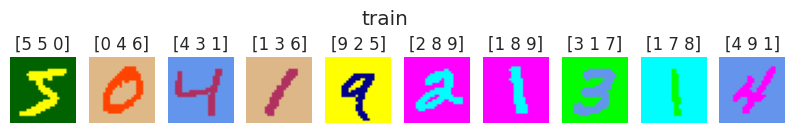

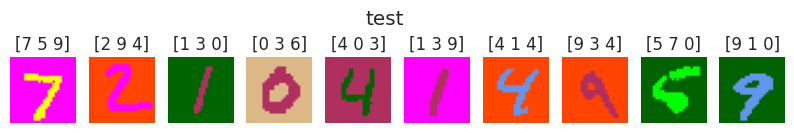

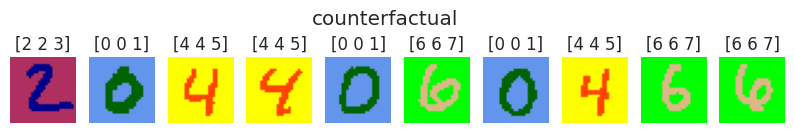

In [7]:
def normalize(img):
    # a = np.expand_dims([0.5, 0.5, 0.5], (0,1))
    normalized = img #* a + a
    return normalized.clip(0, 1)

for n, dataset in zip(['train', 'test', 'counterfactual'], [dataset_train, dataset_test, dataset_counterfactual]):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        sample = dataset[i]
        plt.imshow(normalize(sample['img'].permute(1, 2, 0)))
        plt.title(str(sample['label']))
        plt.axis('off')
    plt.suptitle(n, y=.9)
    plt.show()

In [8]:
BATCH_SIZE = 256
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)
cf_loader = DataLoader(dataset_counterfactual, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

### 2. CVAEGAN

In [13]:
def weights_init(model):
    ''' Инициализация весов генератора и дискриминатора '''

    classname = model.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(self.shape)

def get_one_hot(labels):
    new_ys = []
    for i, label_length in enumerate(LABEL_SIZES):
        new_y = nn.functional.one_hot(labels[:, i].to(torch.int64), int(label_length))
        new_ys.append(new_y)
    new_ys = torch.cat(new_ys, -1)
    return new_ys.to(torch.float32)

In [14]:
class Decoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=30, p=0.1):
        super(Decoder, self).__init__()
        self.label_dim = label_dim
        self.layers = nn.Sequential(
            nn.Linear(z_dim+label_dim, 128*7*7),
            Reshape((-1, 128, 7, 7)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout(p),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.Upsample((14, 14)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.Upsample((28, 28)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, z, labels):
        data = torch.cat([z, get_one_hot(labels)], dim=1)
        prob_output = self.layers(data)
        return prob_output

class Encoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=30, p=0.1):
        super(Encoder, self).__init__()
        self.label_dim = label_dim
        self.layers = nn.Sequential(
            nn.Conv2d(3+label_dim, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p)
        )
        self.fc_output_loc = nn.Linear(2304, z_dim)
        self.fc_output_scale = nn.Linear(2304, z_dim)

    def forward(self, x, labels):
        labels = get_one_hot(labels).T
        labels = labels.expand([28, 28, self.label_dim, labels.size(1)]).T
        data = torch.cat([x, labels], dim=1)  # (BS, 33, 28, 28)
        hidden = self.layers(data)
        z_loc = self.fc_output_loc(hidden)
        z_scale = torch.exp(self.fc_output_scale(hidden))
        return z_loc, z_scale

class Discriminator(nn.Module):
    def __init__(self, label_dim=30, p=0.3):
        super(Discriminator, self).__init__()
        self.label_dim = label_dim
        self.layers = nn.Sequential(
            nn.Conv2d(3+label_dim, 128, 5, 2, 1),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p),
            nn.Linear(2304, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        labels = get_one_hot(labels).T
        labels = labels.expand([28, 28, self.label_dim, labels.size(1)]).T
        data = torch.cat([x, labels], dim=1)  # (BS, 33, 28, 28)
        return self.layers(data)

In [15]:
# enc = Encoder().to('cuda')
# summary(enc, ([(3, 28, 28), (3,)]))

In [16]:
def get_random_comb(batch_size, device):
    # Generates a non-CF combination
    CF_combinations = torch.tensor([
        [0, 0, 1],
        [2, 2, 3],
        [4, 4, 5],
        [6, 6, 7],
        [8, 8, 9]
    ], device=device)

    def is_forbidden(tensor):
        return any(torch.all(tensor == comb, dim=1).any() for comb in CF_combinations)

    tensor = torch.randint(low=0, high=10, size=(batch_size, 3), device=device)

    for i in range(batch_size):
        while is_forbidden(tensor[i].unsqueeze(0)):
            tensor[i] = torch.randint(low=0, high=10, size=(1, 3), device=device)
    return tensor

In [17]:
class CVAE_GAN(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=30, p=0.2, use_cuda=False):
        super().__init__()
        self.encoder_ = Encoder(z_dim, label_dim=label_dim, p=p)
        self.decoder_ = Decoder(z_dim, label_dim=label_dim, p=p)
        self.discriminator_ = Discriminator(label_dim, p=p)
        if use_cuda:
            self.cuda()
        self.device = 'cuda' if use_cuda else 'cpu'
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.label_dim = label_dim

    def model(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        self.discriminator_.train(False)
        pyro.module("decoder", self.decoder_)

        with pyro.plate("data", x.shape[0]):
            # pior for Z
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # decode img using z
            loc_img = self.decoder_(z, labels)
            pyro.sample("obs", dist.Bernoulli(loc_img.squeeze()).to_event(3), obs=x.squeeze())

            # is_real part
            prob_real = self.discriminator_(loc_img, labels).squeeze()
            prob_real = prob_real.expand([28*28*3, *prob_real.shape]).T
            ones = torch.full((x.shape[0],), 1., dtype=torch.float, device=self.device)
            ones = ones.expand([28*28*3, *ones.shape]).T
            pyro.sample("is_real", dist.Bernoulli(prob_real).to_event(1), obs=ones)

    def guide(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        pyro.module("encoder", self.encoder_)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder_(x, labels)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def model_generate(self, batch_size):
        self.discriminator_.train(False)
        pyro.module("decoder", self.decoder_)
        with pyro.plate("data", batch_size):
            # pior for Z
            z_loc = torch.zeros(torch.Size((batch_size, self.z_dim)), dtype=torch.float, device=self.device)
            z_scale = torch.ones(torch.Size((batch_size, self.z_dim)), dtype=torch.float, device=self.device)
            z = dist.Normal(z_loc, z_scale).rsample()

            # random labels for generation
            # rand_labels = torch.randint(low=0, high=10, size=(batch_size, 3), device=self.device)
            rand_labels = get_random_comb(batch_size, self.device)
            loc_img = self.decoder_(z, rand_labels)
            prob_real = self.discriminator_(loc_img, rand_labels).squeeze()
            ones = torch.full((batch_size,), 1., dtype=torch.float, device=self.device)
            pyro.sample("obs", dist.Bernoulli(prob_real), obs=ones)

    def guide_generate(self, batch_size):
        pass

    def encoder(self, x, labels, return_cpu=True):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        z_loc, z_scale = self.encoder_(x, labels)
        if self.use_cuda and return_cpu:
            z_loc = z_loc.cpu()
            z_scale = z_scale.cpu()
        return z_loc, z_scale

    def decoder(self, z, labels, return_cpu=True):
        if self.use_cuda:
            z = z.cuda()
            labels = labels.cuda()
        loc_img = self.decoder_(z, labels)
        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

    def reconstruct_img(self, x, labels, return_cpu=True):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        z_loc, z_scale = self.encoder_(x, labels)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder_(z, labels)
        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA = torch.cuda.is_available()
one = 1.
zero = 0.

def train_discriminator(model, optimizer, criterion, real_batch, real_labels, label_dim=30, z_dim=Z_DIM):
    model.discriminator_.zero_grad()
    model.discriminator_.train(True)
    batch_size = real_batch.size(0)

    ## Обучение по реальным объетам
    ones = torch.full((batch_size,), one, dtype=torch.float, device=device)
    output = model.discriminator_(real_batch, real_labels).view(-1)
    error_real = criterion(output, ones)
    error_real.backward()
    mean_real = output.mean().item()


    ## Обучение по восстановленным объектам
    zeros = torch.full((batch_size,), zero, dtype=torch.float, device=device)
    # Восстановленные объекты
    predicted_batch = model.reconstruct_img(real_batch, real_labels, return_cpu=False)

    output = model.discriminator_(predicted_batch, real_labels).view(-1)
    error_predicted = criterion(output, zeros)
    error_predicted.backward()
    mean_predicted = output.mean().item()


    ## Обучение по сгенерированным объектам
    zeros = torch.full((batch_size,), zero, dtype=torch.float, device=device)
    # Сгенерированные объекты
    # rand_labels = torch.randint(low=0, high=10, size=(real_batch.shape[0], 3), device=device)
    rand_labels = get_random_comb(real_batch.shape[0], device)
    noise = torch.randn(real_batch.shape[0], z_dim, device=device)
    fake_batch = model.decoder(noise, rand_labels, return_cpu=False).detach()

    output = model.discriminator_(fake_batch, rand_labels).view(-1)
    error_fake = criterion(output, zeros)
    error_fake.backward()
    mean_fake = output.mean().item()

    # Считаем общую ошибку
    error = error_real + error_predicted + error_fake
    # Обновляем веса дискриминатора
    optimizer.step()
    return error, mean_real, mean_predicted, mean_fake


def train_vae(model, svi_vae, svi_generator, real_batch, real_labels):
    model.discriminator_.train(False)
    model.encoder_.zero_grad()
    model.decoder_.zero_grad()

    elbo1 = -svi_vae.step(real_batch, real_labels)
    elbo2 = -svi_generator.step(real_batch.shape[0])
    return elbo1 + elbo2


def callback(losses_elbo, losses_discriminator, D_real_means, D_fake_means,
             DG_fake_means, it):
    clear_output(wait=True)
    plt.figure(figsize=(20, 5), constrained_layout=False)
    plt.suptitle(f'Итерация {it}', y=1.02)
    plt.subplot(131)
    plt.plot(losses_discriminator, lw=2, label='дискр.')
    plt.title('BCELoss')
    plt.legend()
    plt.xlabel('Номер итерации')
    plt.subplot(132)
    plt.plot(losses_generator, lw=2, label='VAE')
    plt.title('ELBO')
    plt.legend()
    plt.xlabel('Номер итерации')
    plt.subplot(133)
    plt.plot(D_real_means, lw=2, label='реальные', alpha=0.7)
    plt.plot(D_fake_means, lw=2, label='сгенер.', alpha=0.7)
    plt.plot(DG_fake_means, lw=2, label='восст.', alpha=0.7)
    plt.title('Среднее значение выхода дискриминатора')
    plt.ylabel('Вероятность истинности картинки')
    plt.xlabel('Номер итерации')
    plt.legend()
    plt.tight_layout()
    plt.show()

### 3. Inference (1999 epochs, all combs)

In [19]:
pyro.clear_param_store()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = CVAE_GAN(p=0.2, use_cuda=torch.cuda.is_available())
vae.load_state_dict(torch.load('/content/vaegan_zdim10_it1999.pt', map_location='cpu'))

<All keys matched successfully>

#### Metrics

In [20]:
NUM_PER_COMB = 32
all_combinations = []
for digit in range(10):
    for fg_color in range(10):
        for bg_color in range(10):
            all_combinations.append([digit, fg_color, bg_color])
all_combinations = torch.tensor(all_combinations).repeat(NUM_PER_COMB, 1)  # (32K, 3)
label_loader = DataLoader(all_combinations, batch_size=256, shuffle=True, num_workers=2)

In [ ]:
results = defaultdict(list)
for fixed_labels in tqdm(label_loader):
    fixed_noise = torch.randn(len(fixed_labels), Z_DIM, device=device)
    with torch.no_grad():
        fake = vae.decoder(fixed_noise, fixed_labels).detach().cpu()
    for l, gen in zip(fixed_labels, fake):
        results[''.join([str(t) for t in l.tolist()])].append(gen)
for k, img in results.items():
    results[k] = torch.stack(results[k])

  6%|▋         | 8/125 [00:18<04:16,  2.20s/it]

In [ ]:
train_imgs, train_labels, cf_imgs, cf_labels = [], [], [], []
cf_combinations = ['001', '223', '445', '667', '889']
for k, img in results.items():
    if k in cf_combinations:
        cf_imgs.append(img)
        cf_labels.append(torch.tensor([[int(t) for t in list((k))]] * len(img)))
    else:
        train_imgs.append(img)
        train_labels.append(torch.tensor([[int(t) for t in list((k))]] * len(img)))

train_imgs = torch.concatenate(train_imgs)  # [31840, 3, 28, 28]
cf_imgs = torch.concatenate(cf_imgs)  # [160, 3, 28, 28]
train_labels = torch.concatenate(train_labels) # [31840, 3]
cf_labels = torch.concatenate(cf_labels) # [160, 3]
train_imgs.shape, train_labels.shape, cf_imgs.shape, cf_labels.shape

(torch.Size([31840, 3, 28, 28]),
 torch.Size([31840, 3]),
 torch.Size([160, 3, 28, 28]),
 torch.Size([160, 3]))

In [ ]:
class DatasetForInference(Dataset):
    def __init__(self, imgs, labels):
        self.imgs = imgs
        self.labels = labels

    def __getitem__(self, idx):
        ret = {
            'img': self.imgs[idx],
            'label': self.labels[idx],
        }
        return ret

    def __len__(self):
        return self.labels.shape[0]


train_inf_dataset = DatasetForInference(train_imgs, train_labels)
cf_inf_dataset = DatasetForInference(cf_imgs, cf_labels)

BS = 32
train_inf_loader = DataLoader(train_inf_dataset, batch_size=BS, shuffle=True, num_workers=2)
cf_inf_loader = DataLoader(cf_inf_dataset, batch_size=BS, shuffle=False, num_workers=2)

device = f"cuda" if torch.cuda.is_available() else "cpu"
simple_cnn = nn.Sequential(
    nn.Conv2d(3, 32, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Conv2d(32, 64, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.4),
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=30)
).to(device)

simple_cnn.load_state_dict(torch.load('classifier.pth', map_location='cpu'))

<All keys matched successfully>

In [ ]:
T = transforms.Compose([
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def get_winner_probs(loader):
    with torch.no_grad():
        winner_probs_1 = []
        winner_probs_2 = []
        winner_probs_3 = []
        for batch in tqdm(loader):
            X_batch = batch['img']
            y_batch = batch['label']
            logits = simple_cnn(T(X_batch)) # (BS, 30)
            y1_preds = F.softmax(logits[:, :10], dim=-1)
            real_y1 = y_batch[:, 0]
            y2_preds = F.softmax(logits[:, 10:20], dim=-1)
            real_y2 = y_batch[:, 1]
            y3_preds = F.softmax(logits[:, 20:], dim=-1)
            real_y3 = y_batch[:, 2]

            winner_probs_1.extend(y1_preds[np.arange(BS), real_y1].numpy())
            winner_probs_2.extend(y2_preds[np.arange(BS), real_y2].numpy())
            winner_probs_3.extend(y3_preds[np.arange(BS), real_y3].numpy())
        return np.stack([winner_probs_1, winner_probs_2, winner_probs_3])

In [ ]:
# bigger gen, june 03
winners_train = get_winner_probs(train_inf_loader)
winners_cf = get_winner_probs(cf_inf_loader)

print('\nTRAIN:', np.mean(winners_train, axis=1))
print('CF:   ', np.mean(winners_cf, axis=1))

100%|██████████| 5/5 [00:00<00:00, 17.11it/s]


TRAIN: [0.6157026  0.946444   0.98040384]
CF:    [0.0746655  0.98892725 0.9812006 ]


In [ ]:
# smaller gen, june 02
winners_train = get_winner_probs(train_inf_loader)
winners_cf = get_winner_probs(cf_inf_loader)

print('\nTRAIN:', np.mean(winners_train, axis=1))
print('CF:   ', np.mean(winners_cf, axis=1))

100%|██████████| 5/5 [00:00<00:00, 13.60it/s]


TRAIN: [0.51509845 0.94974864 0.9787875 ]
CF:    [0.25799826 0.98067075 0.9934246 ]


#### Результаты

Отключим режим обучения

In [ ]:
vae.train(False);

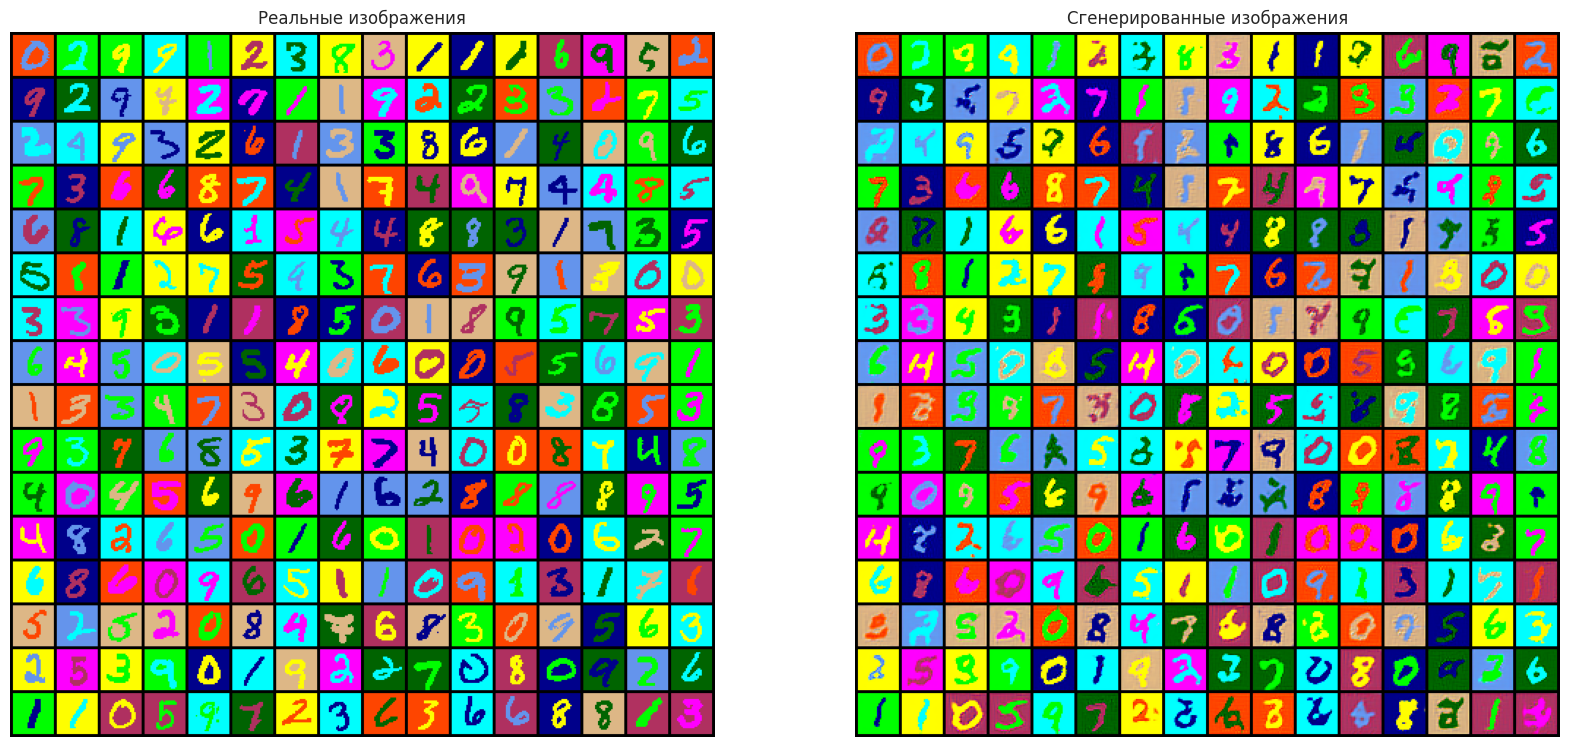

In [ ]:
# Извлечем батч реальных изображений
real_batch = next(iter(train_loader))

# Создадим фиксированный батч латентных векторов для визуализации
fixed_noise = torch.randn(BATCH_SIZE, Z_DIM, device=device)
fixed_markers = real_batch['label']

with torch.no_grad():
    fake = vae.decoder(fixed_noise, fixed_markers).detach().cpu()
fake = vutils.make_grid(fake, nrow=16, padding=2, normalize=True)

# Рисуем реальные изображения
plt.figure(figsize=(20, 11))
plt.subplot(121)
plt.axis("off")
plt.title("Реальные изображения")
plt.imshow(np.transpose(vutils.make_grid(
    real_batch['img'].to(device)[:256], nrow=16, padding=2, normalize=True
).cpu(), (1,2,0)))

# Рисуем сгенерированные изображения
plt.subplot(122)
plt.axis("off")
plt.title("Сгенерированные изображения")
plt.imshow(np.transpose(fake, (1,2,0)))
plt.show()

DIGIT: 0


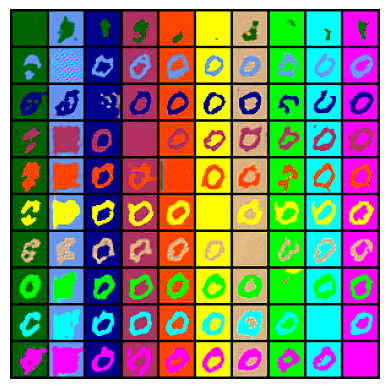

DIGIT: 1


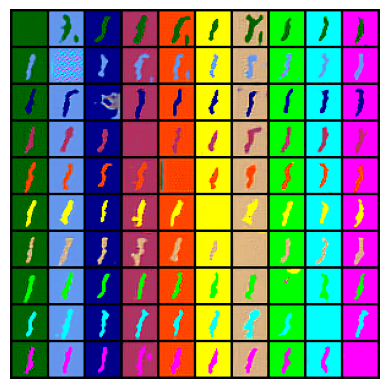

DIGIT: 2


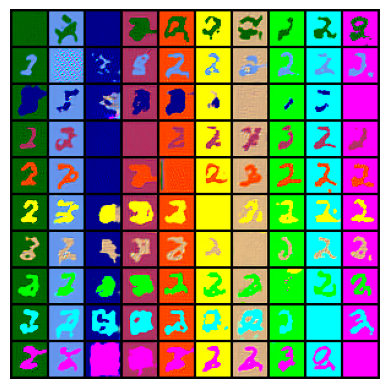

DIGIT: 3


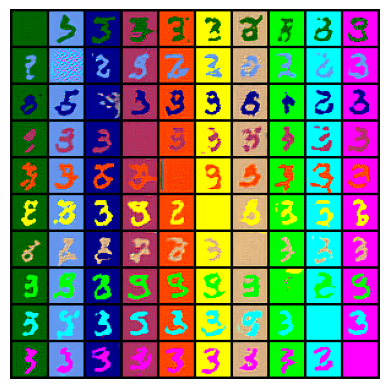

DIGIT: 4


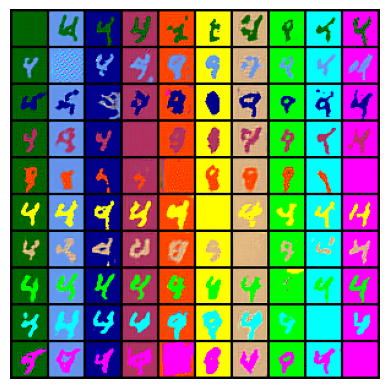

DIGIT: 5


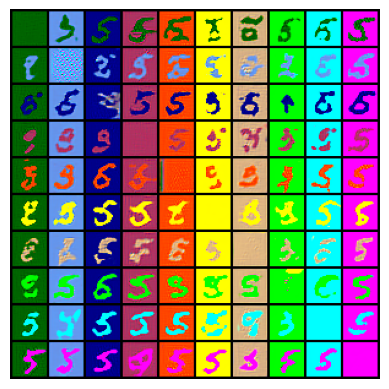

DIGIT: 6


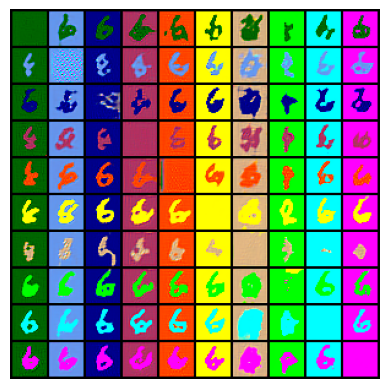

DIGIT: 7


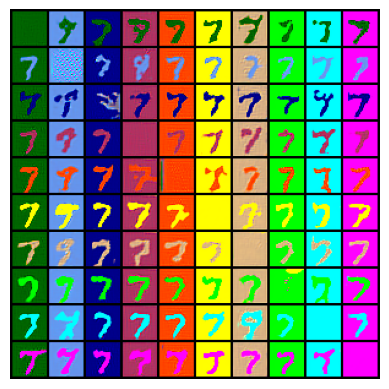

DIGIT: 8


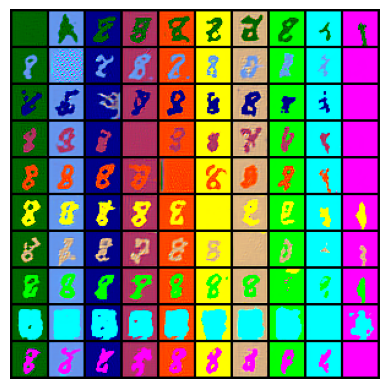

DIGIT: 9


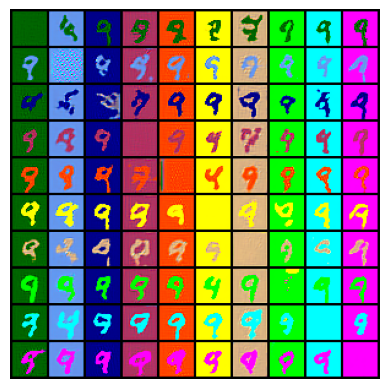

In [ ]:
all_combinations = []
for digit in range(10):
    for fg_color in range(10):
        for bg_color in range(10):
            all_combinations.append([digit, fg_color, bg_color])
all_combinations = torch.tensor(all_combinations)  # (1000, 3)
label_loader = DataLoader(all_combinations, batch_size=256, shuffle=False, num_workers=2, drop_last=False)

results = []
for fixed_labels in label_loader:
    fixed_noise = torch.randn(len(fixed_labels), Z_DIM, device=device)
    with torch.no_grad():
        fake = vae.decoder(fixed_noise, fixed_labels).detach().cpu()
    results.append(fake)
results = torch.concatenate(results)

for i in range(10):
    print('DIGIT:', i)
    gen_img = vutils.make_grid(results[i*100:(i+1)*100], nrow=10, padding=2, normalize=True)
    plt.axis("off")
    plt.imshow(np.transpose(gen_img, (1,2,0)))
    plt.show()

Посмотрим на качество преобразуемых картин

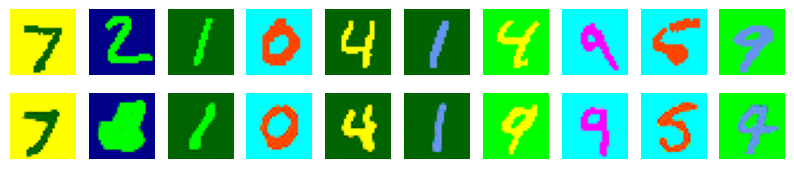

In [ ]:
for batch in test_loader:
    x, l = batch['img'], batch['label']
    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(2, 10, i+1)
        plt.imshow(np.transpose(x[i].clamp(0, 1), (1,2,0)))
        plt.axis('off')
        plt.subplot(2, 10, i+11)
        recon = vae.reconstruct_img(x[i:i+1], l[i:i+1]).squeeze().detach().clamp(0, 1).numpy()
        plt.imshow(np.transpose(recon, (1,2,0)))
        plt.axis('off')
    break

Попробуем сгенерировать новые изображения цифр, сгенерировав 75 точек из скрытого пространства из распределения $\mathcal{N}(0, I_2)$. Далее для подачи на вход декодеру ко всем этом уже зафиксированным 75 точкам будет присоединять метку класса.

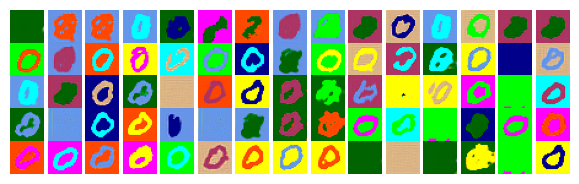

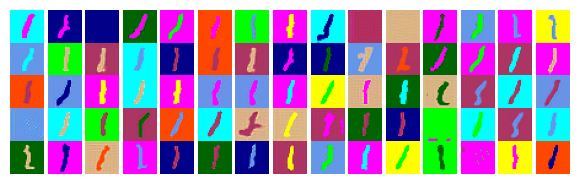

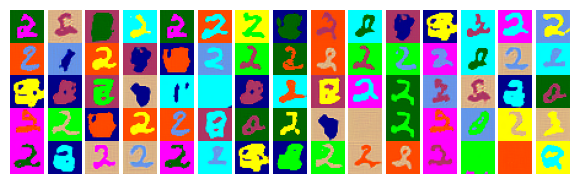

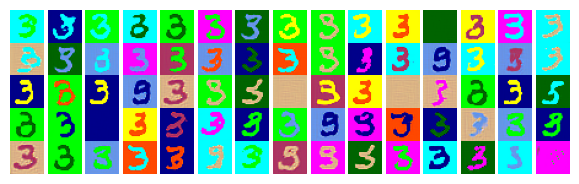

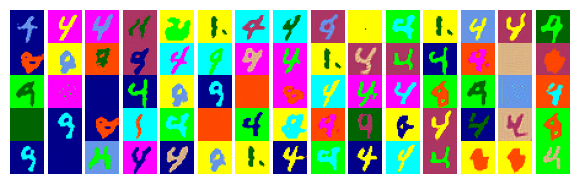

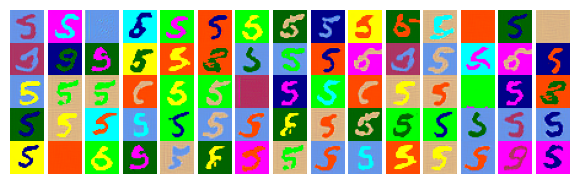

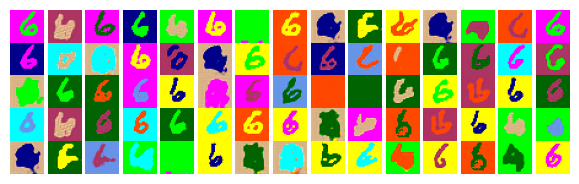

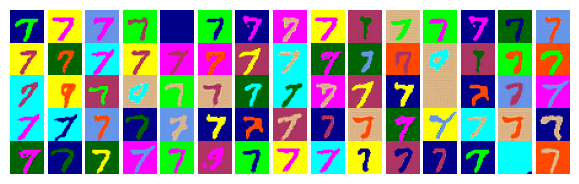

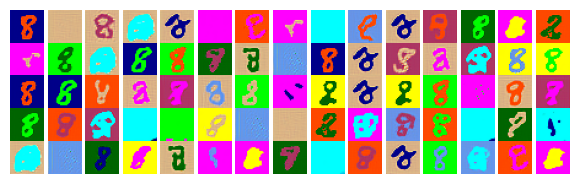

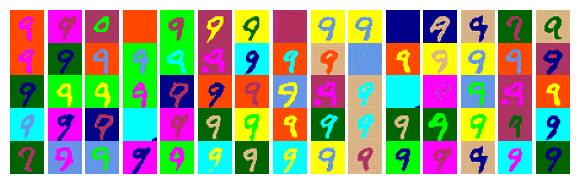

In [ ]:
n_test = 75

# Семплируем из скрытого пространства
y_loc = torch.zeros(torch.Size((n_test, Z_DIM)))
y_scale = torch.ones(torch.Size((n_test, Z_DIM)))
y = dist.Normal(y_loc, y_scale).rsample()

# Для каждого класса
for j in range(10):
    # Метки этого класса
    labels = torch.zeros((n_test, 1), dtype=int) + j
    labels = torch.concatenate([labels, torch.randint(low=0, high=10, size=(n_test, 2), device=device)], dim=1)
    # Получаем изображение
    loc_img = vae.decoder(y, labels)

    # Визуализация
    plt.figure(figsize=(6, 2))
    for i in range(n_test):
        plt.subplot(5, 15, i+1)
        img = loc_img[i].squeeze().detach().numpy()
        plt.imshow(np.transpose(img, (1,2,0)))
        plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(wspace=-0.01, hspace=-0.01)

Трансфер стиля

Возьмем из теста изображение первых 10 семерок и получим для них точку в скрытом пространстве. Далее давайте перед подачей в декодер подменим лэйбл этой точки. На выходе мы получим то, какая могла бы быть цифра другого класса с таким же стилем.

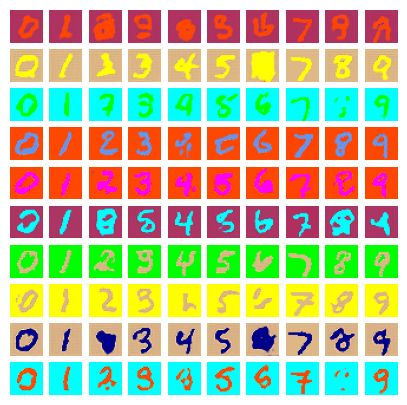

In [ ]:
plt.figure(figsize=(5,5))

count = 0
for batch in test_loader:
    x, l = batch['img'], batch['label']
    for i in range(len(x)):
        if l[i][0] != 7: continue

        # Кодируем цифру с исходной меткой
        z = vae.encoder(x[i:i+1], l[i:i+1])[0]

        # Для каждого класса
        for j in range(10):
            # если исходная метка, то просто берем изображение
            if j == 7:
                img = x[i]
            # иначе подменяем метку и прогоняем через декодер
            else:
                new_l = l[i].clone()
                new_l[0] = j
                img = vae.decoder(z, new_l.unsqueeze(0)).squeeze()

            # Визуализация
            plt.subplot(10, 10, count*10+j+1)
            plt.imshow(np.transpose(img.detach().clamp(0, 1).numpy(), (1,2,0)))
            plt.axis('off')

        count += 1
        if count >= 10: break
    if count >= 10: break